<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/QRS_detection/TCN/full_detection_TCN_QTDB%2BLUDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir /content/physionet.org/
!mkdir /content/physionet.org/files/
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/ludb' '/content/physionet.org/files/'
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/qtdb' '/content/physionet.org/files/'

In [ ]:
!pip install wfdb

# preprocess

In [3]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [4]:
def bandpass_filter(signal, lowcut=0.5, highcut=10, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)

In [5]:

from scipy.signal import resample

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    """
    Rescales annotation sample indices from original_fs to target_fs.
    Works with scalars or lists/arrays.
    """
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)



In [6]:
def extract_wave_regions(samples, symbols, fs, extra_ms=0):
    wave_regions = {'p': [], 'N': [], 't': []}
    start = None
    current_symbol = None
    extra_samples = int((extra_ms / 1000) * fs)

    for i in range(len(symbols)):
        if symbols[i] == '(':
            start = samples[i]
            current_symbol = None
        elif symbols[i] in wave_regions:
            current_symbol = symbols[i]
        elif symbols[i] == ')' and current_symbol:
            end = samples[i] + extra_samples
            if start and end:
              wave_regions[current_symbol].append((int(start), int(end)))
            start = None
            current_symbol = None
    return wave_regions


In [7]:
def create_multi_class_mask(length, wave_regions):
    mask = np.zeros((length, 3))  # [P, QRS, T]
    label_map = {'p': 0, 'N': 1, 't': 2}
    for label, regions in wave_regions.items():
        for start, end in regions:
            mask[start:end, label_map[label]] = 1
    return mask


In [8]:
def segment_signal_and_mask(signal, mask, window_size, fs):
    segments = []
    masks = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        segments.append(segment)
        masks.append(mask_segment)
    return np.array(segments), np.array(masks)


In [9]:

def process_record(record_path, Type, extra_ms=0):
    # Load signal
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]  # Use lead I
    if Type=='QTDB':
      annotations = wfdb.rdann(record_path, 'pu0')
    else:
      annotations = wfdb.rdann(record_path, 'i')
    samples = annotations.sample  # Annotation sample locations
    symbols = annotations.symbol  # Annotation symbols
    fs = record.fs  # Sampling frequency (500 Hz)

    # Preprocess
    signal = normalize_signal(smooth_signal(bandpass_filter(signal,fs=fs)))

    # Resampling to 250 Hz
    if fs!=250:
      # Example: Resample QTDB signal from 500 Hz to 250 Hz
      signal = resample_signal(signal, original_fs=fs, target_fs=250)

      # Example: Adjust QTDB annotations
      samples = adjust_annotations(samples,original_fs=fs,target_fs=250)
      fs=250
    # Extract QRS
    if Type=='QTDB':
      qrs_regions = extract_wave_regions(samples, symbols,fs,extra_ms=extra_ms)
    else :
      qrs_regions = extract_wave_regions(samples, symbols,fs)
    # Create binary masks
    mask = create_multi_class_mask(len(signal), qrs_regions)

    # Segment the signals and masks
    #window_size = int(1 * fs)  # 1-second window (based on LUDB's fs)
    window_size = int(1 * fs)  # 150 ms window (based on LUDB's fs)
    segments, masks = segment_signal_and_mask(signal, mask, window_size, fs)

    return segments, masks


In [10]:
def get_all_records(directory, extension=".dat"):
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    return list(set(files))  # Ensure no duplicates

# Set paths for QTDB and LUDB
qtdb_path = "/content/physionet.org/files/qtdb/1.0.0/"
ludb_path = "/content/physionet.org/files/ludb/1.0.1/data/"

# Get all record names dynamically
qt_records = get_all_records(qtdb_path)
lu_records = get_all_records(ludb_path)

print(f"Found {len(qt_records)} QTDB records and {len(lu_records)} LUDB records.")

Found 105 QTDB records and 200 LUDB records.


In [ ]:
qt_segments_list, qt_masks_list = [], []

for record_path in qt_records:
    try:
        print(f"Processing {record_path}")
        segments, masks = process_record(qtdb_path+record_path, Type='QTDB', extra_ms=20)  # Resample to 250 Hz
        qt_segments_list.append(segments)
        qt_masks_list.append(masks)
    except:
        print(f"Skipping {record_path} due to error.")

In [ ]:

lu_segments_list, lu_masks_list = [], []
for record_path in lu_records:
    try:
        print(f"Processing {record_path}")
        segments, masks = process_record(ludb_path+record_path, Type='LUDB', extra_ms=0)
        lu_segments_list.append(segments)
        lu_masks_list.append(masks)
    except:
        print(f"Skipping {record_path} due to error.")

In [13]:
qt_segments = np.concatenate(qt_segments_list, axis=0)
qt_masks = np.concatenate(qt_masks_list, axis=0)
lu_segments = np.concatenate(lu_segments_list, axis=0)
lu_masks = np.concatenate(lu_masks_list, axis=0)

In [14]:
# Combine into final dataset
X = np.concatenate([qt_segments, lu_segments])
y = np.concatenate([qt_masks, lu_masks])

# split dataset

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# model and training

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, Dense, Dropout
from tensorflow.keras.metrics import Recall, Precision
import tensorflow as tf
def TCN(input_shape, num_filters, kernel_size, num_blocks, dropout_rate):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        res = x
        x = Conv1D(num_filters, kernel_size, padding='causal', dilation_rate=2**_)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Dropout(dropout_rate)(x)
        x = Conv1D(num_filters, kernel_size, padding='causal', dilation_rate=2**_)(x)
        x = BatchNormalization()(x)
        x = Add()([x, res])
        x = ReLU()(x)
    x = Conv1D(3, kernel_size=1, activation='sigmoid')(x)
    model = Model(inputs, x)
    return model

# Example usage
window_size = int(1 * 250)  # 1 second
input_shape = (window_size, 1)
model = TCN(input_shape, num_filters=128, kernel_size=3, num_blocks=6, dropout_rate=0.3)
def weighted_binary_crossentropy(y_true, y_pred):
    # Adjust weights based on class imbalance
    weight = tf.reduce_mean(y_true) * 0.5 + 0.5
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(loss * weight)

model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])

In [18]:
# Reshape data for TCN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 89s 23ms/step - accuracy: 0.6796 - loss: 0.0695 - val_accuracy: 0.6742 - val_loss: 0.0632
Epoch 2/10
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 136s 22ms/step - accuracy: 0.6776 - loss: 0.0643 - val_accuracy: 0.6933 - val_loss: 0.0591
Epoch 3/10
 733/3848 ━━━━━━━━━━━━━━━━━━━━ 1:03 20ms/step - accuracy: 0.6760 - loss: 0.0625

KeyboardInterrupt: 

In [19]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_acc} , Test Loss: {test_loss}")

# Predict on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks



1203/1203 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6858 - loss: 0.0576
Test Accuracy: 0.6864716410636902 , Test Loss: 0.05753183364868164
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


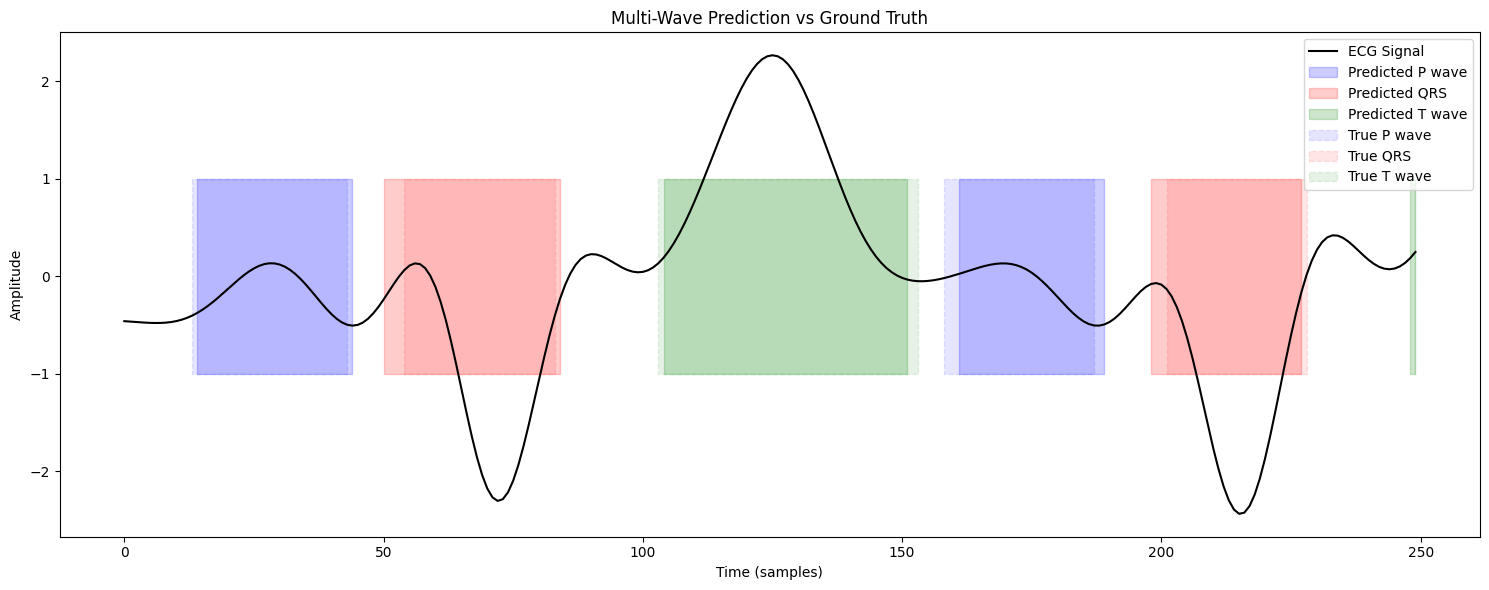

In [20]:
import matplotlib.pyplot as plt
import numpy as np

index = 0  # Sample to visualize
signal = X_test[index].flatten()
pred_mask = y_pred[index]
true_mask = y_test[index]
time = np.arange(len(signal))

plt.figure(figsize=(15, 6))
plt.plot(time, signal, color='black', label='ECG Signal')

# Plot predicted masks
plt.fill_between(time, -1, 1, where=pred_mask[:, 0] > 0.5, color='blue', alpha=0.2, label='Predicted P wave')
plt.fill_between(time, -1, 1, where=pred_mask[:, 1] > 0.5, color='red', alpha=0.2, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=pred_mask[:, 2] > 0.5, color='green', alpha=0.2, label='Predicted T wave')

# Plot ground truth masks
plt.fill_between(time, -1, 1, where=true_mask[:, 0] > 0.5, color='blue', alpha=0.1, label='True P wave', linestyle='dashed')
plt.fill_between(time, -1, 1, where=true_mask[:, 1] > 0.5, color='red', alpha=0.1, label='True QRS', linestyle='dashed')
plt.fill_between(time, -1, 1, where=true_mask[:, 2] > 0.5, color='green', alpha=0.1, label='True T wave', linestyle='dashed')

plt.title('Multi-Wave Prediction vs Ground Truth')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [28]:
from keras.saving import save_model

# Save the trained model
save_model(model,"/content/drive/MyDrive/Final project/QRS detection/TCN/first_QRS_T_P.keras")
model.save("/content/drive/MyDrive/Final project/QRS detection/TCN/first_QRS_T_P.keras")

# Model Test

In [23]:

!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/mitdb' '/content/physionet.org/files/'

In [24]:
import wfdb

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/physionet.org/files/mitdb/1.0.0/108')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)

(3600,)


In [25]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

first_10_seconds = normalize_signal(smooth_signal(bandpass_filter(first_10_seconds,fs=new_fs)))
first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size , 250)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(12, 360, 1)


In [ ]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.1).astype(int)  # Convert probabilities to binary masks
print(y_pred[y_pred > 0])  # P


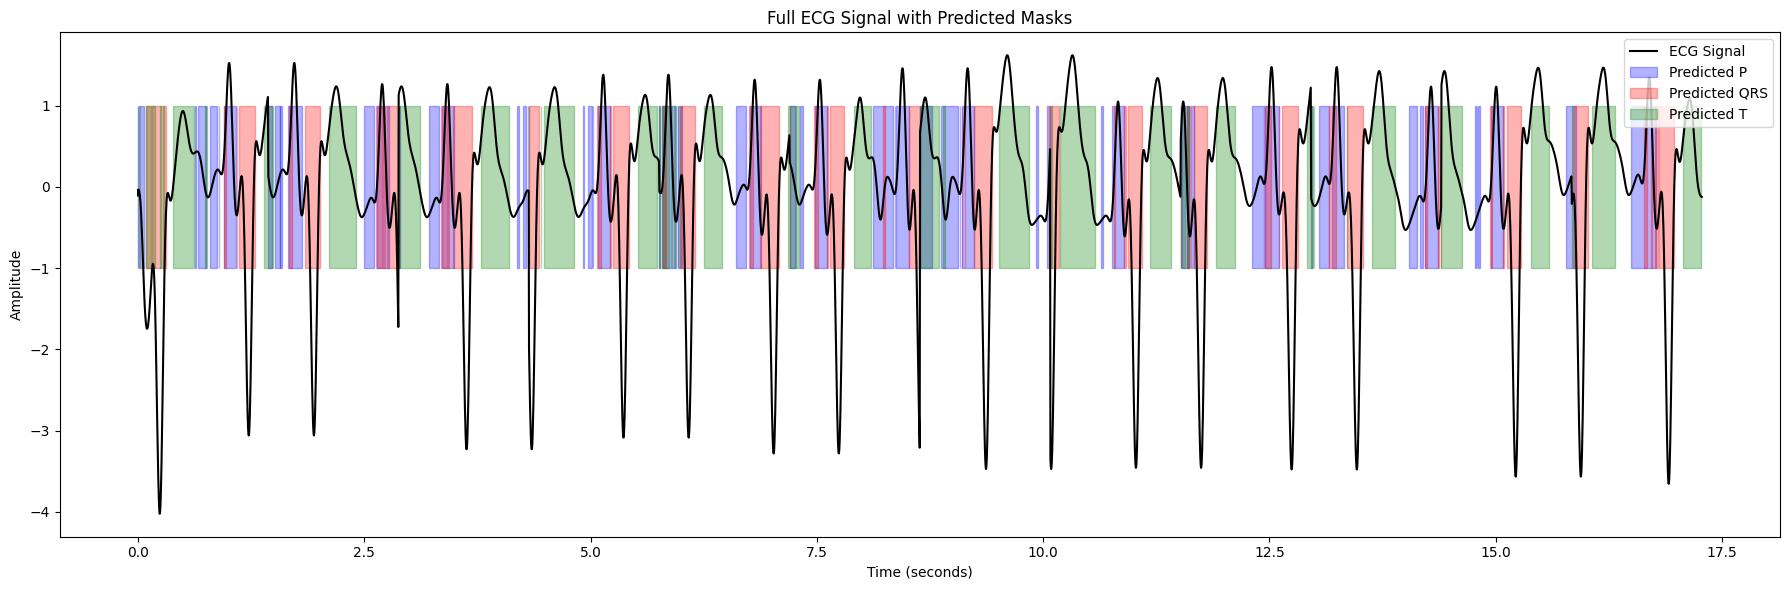

In [31]:
full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

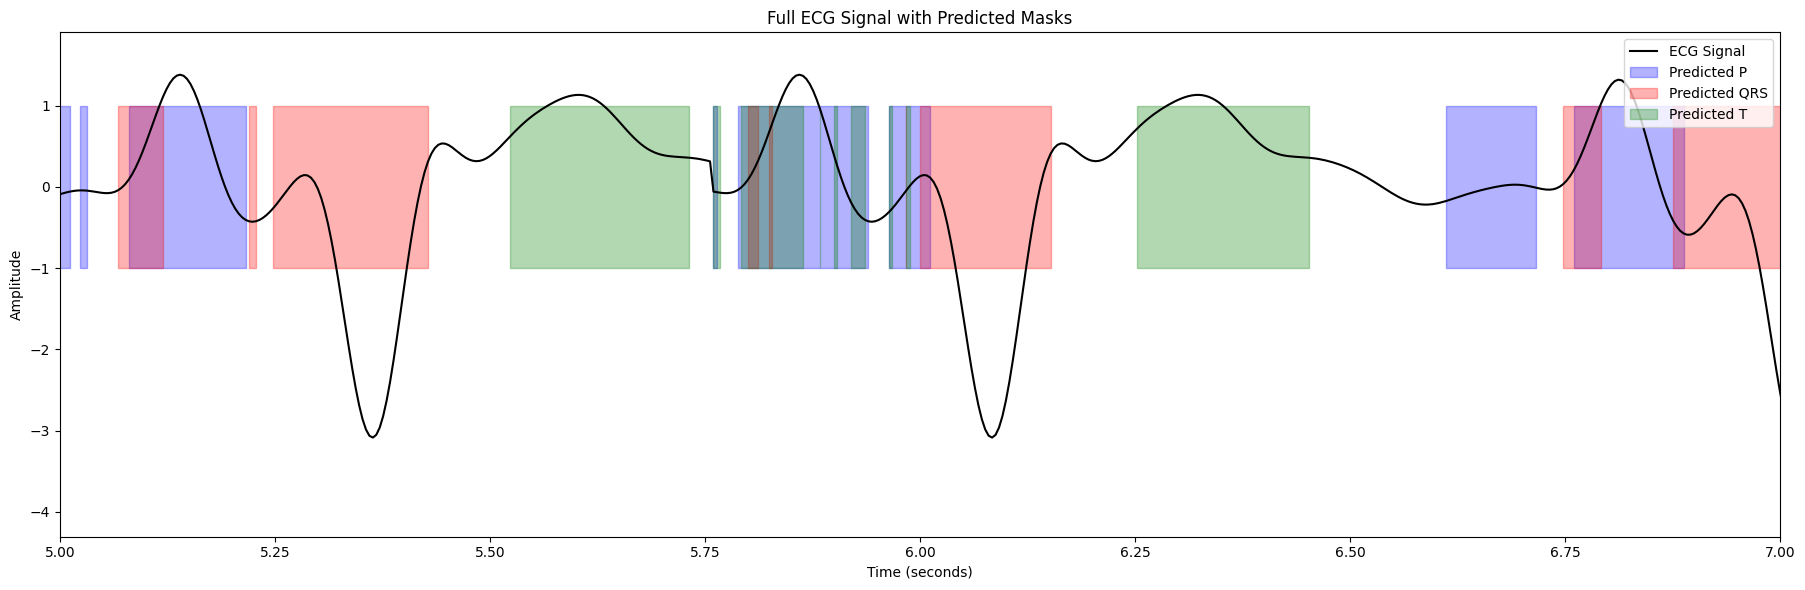

In [30]:
full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.xlim(5, 7)  # Zoom into 5s to 7s
plt.show()